# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Data Sets

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

**portfolio.json**

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement

The goal of the project is to take advantage of the behavior like the Profile General Distribution - Age, Income, Gender, Event.

## Problem Soultion

* Data Pre-processing (Cleaning the data, Merging the data, and etc.)
* Data Exploration (Income distribution vs. gender, Trencript distribution as a function a gender and Offer type distribution)
* Building a ML Model (Decision Tree Classifier , Support Vector Machine)

## Explaionary Data Analysis

In [1]:
import re
import math
import json
import progressbar
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Access Portfolio Data

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# checking the columns' titles and datatypes
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# checking for the existence of missing values(NaNs)
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

In [7]:
# checking the number of rows and columns of the dataset
portfolio.shape

(10, 6)

In [8]:
# checking the offer types the customer can receive
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [9]:
# checking the number of unique offers
portfolio['id'].nunique()

10

In [10]:
# grouping the offers by their type 
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

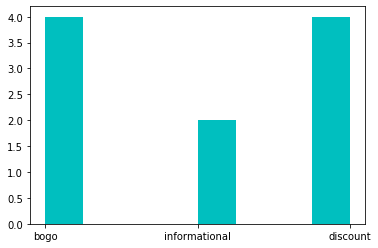

In [11]:
plt.hist(portfolio['offer_type'], bins=8 , color = 'c');
plt.savefig('offer_typePlot.png', dpi=300, bbox_inches='tight')

**Portfolio Dataset shows the dataset has no null values nor duplicates. 
<br> Also, There are 3 types of offers : 
<br> -'bogo'(Buy One Get One free), 'informational' and 'discount'.
<br> There are 
<br> 4 offers in the dataset that are classified as :“bogo“
<br> 4 offers classified as : ”discount”  
 2 offers classified as : “informational”.**

### 2. Access Profile Data

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
# checking the number of rows and columns of the dataset
profile.shape

(17000, 5)

In [15]:
# checking for the existence of missing values(NaNs)
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [16]:
# checking for duplicates
profile.columns.duplicated().sum()

0

In [17]:
# checking the number unique customers
profile['id'].nunique()

17000

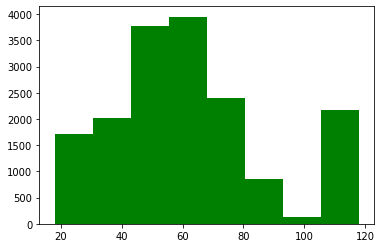

In [18]:
# checking the distribution of 'Age' column
plt.hist(profile['age'], bins=8 , color = 'green');
plt.savefig('AgePlot.png', dpi=300, bbox_inches='tight')

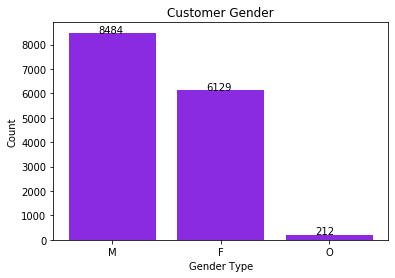

In [19]:
# checking the distribution of 'Gender' column
gender_counts = profile.gender.value_counts()
x = ['M','F','O']
plt.bar(x,height = gender_counts, color = 'blueviolet');
xlocs, xlabs = plt.xticks()
for i, v in enumerate(gender_counts):
    plt.text(xlocs[i] - 0.13, v , str(v))
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('Customer Gender');
plt.savefig('GenderPlot.png', dpi=300, bbox_inches='tight')

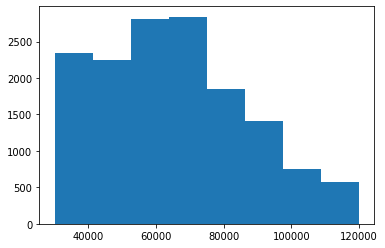

In [20]:
# checking the distribution of 'income' column
profile['income'].hist(grid=False ,  bins=8);
plt.savefig('incomePlot.png', dpi=300, bbox_inches='tight')

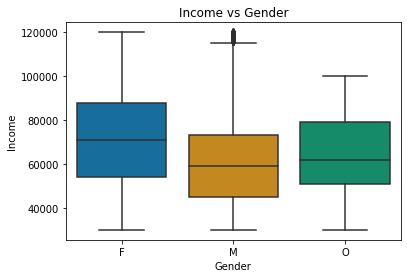

In [21]:
sns.boxplot(profile['gender'], profile['income'] , palette="colorblind"  )
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.savefig('hhnPlot.png', dpi=300, bbox_inches='tight')
plt.show();


In [22]:
# change gendr column
Key = { 'F': 1, 'M': 2, 'O':3 }
profile.replace({'gender': Key}, inplace=True)

In [23]:
profile=profile.dropna()

In [24]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [25]:
profile.head()

,gender,age,id,became_member_on,income
1,1.0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,1.0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,2.0,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,2.0,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,2.0,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


### 3. Access Transcript Data

In [26]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
# checking the number of rows and columns of the dataset
transcript.shape

(306534, 4)

In [28]:
# checking for duplicates
transcript.columns.duplicated().sum()

0

In [29]:
# checking the columns' titles and datatypes 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [30]:
# checking for the existence of missing values(NaNs)
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [31]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

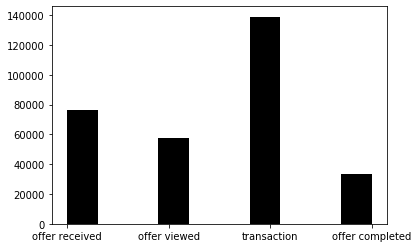

In [32]:
plt.hist(transcript['event'], bins=10 , color = 'Black');
plt.savefig('eventPlot.png', dpi=300, bbox_inches='tight')

## Data Cleaning & Analysis

In [33]:
# rename customer id column..
portfolio.rename(columns = {"id": "offer_id"}, inplace = True)

In [34]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [35]:
# checking the number of customers that are registered at the age = 118
profile['age'][profile['age'] == 118].count()

0

In [36]:
# checking the count of values of the rows into which the customers age = 118
profile[profile['age']==118].count()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [37]:
# Remove outliers (age 118)
profile = profile[profile.age < 118].reset_index(drop=True)

In [38]:
# checking the count of values of the rows after Remove outliers (age 118)
profile[profile['age']==118].count()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [39]:
# rename customer id column..
profile.rename(columns = {"id": "customer_id"}, inplace = True)

In [40]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,1.0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,1.0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,2.0,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,2.0,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,2.0,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [41]:
# quick check for null values in dataset
profile.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

In [42]:
# transform the became_member_on column to a datetime object..
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

In [43]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,1.0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,1.0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,2.0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,2.0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,2.0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [44]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [45]:
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [46]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts, event_counts.index.values)),
                            columns=['Counts', 'Event'])

In [47]:
event_counts

,Counts,Event
0,138953,transaction
1,76277,offer received
2,57725,offer viewed
3,33579,offer completed


In [48]:
#Compute the percentage of customer transaction and offer events
sum_transactions = event_counts['Counts'].sum()

transactions = 100 * event_counts.iloc[0]['Counts'] / sum_transactions
offers = 100 * event_counts.iloc[1:]['Counts'].sum() / sum_transactions

In [49]:
transactions , offers

(45.33037118231583, 54.66962881768417)

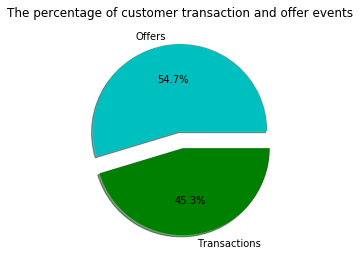

In [50]:
values = [45.33, 54.66]

colors = ['g', 'c']

labels = ['Transactions', 'Offers']

explode = (0.2, 0)

plt.pie(values, colors=colors, labels=labels,

explode=explode, autopct='%1.1f%%',

counterclock=False, shadow=True)

plt.title('The percentage of customer transaction and offer events')
plt.savefig('percentagePlot.png', dpi=300, bbox_inches='tight')

plt.show()


In [51]:
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [52]:
transcript = transcript.loc[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')]

In [53]:
def transcript_prepar(transcript):
    
   #Create separate columns for amount, reward and offer_id from value column.

    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0
    #Iterate over value column, check it and update offer_id, amount, reward columns
    for index, row in transcript.iterrows():
        for i in row['value']:
            if i == 'offer_id' or i == 'offer id':
                transcript.at[index, 'offer_id']= row['value'][i]
            if i == 'amount':
                transcript.at[index, 'amount']= row['value'][i]
            if i == 'reward':
                transcript.at[index, 'reward']= row['value'][i]
   
    # map offer type to offer id           
    offers_map = {
        'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
        '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
        '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
        '2906b810c7d4411798c6938adc9daaa5':'discount',
        'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
        '3f207df678b143eea3cee63160fa8bed':'informational',
        '5a8bc65990b245e5a138643cd4eb9837':'informational',
         
        
    }
        
     # Drop value column
    transcript.drop('value', axis = 1, inplace = True)
    
    #create offer_type column 
    transcript['offer_type'] = transcript['offer_id'].map(offers_map)
    
    return transcript

In [54]:
transcript.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0


In [55]:
# update transcript 
transcript = transcript_prepar(transcript)

In [56]:
transcript = pd.get_dummies(transcript, columns=['event'], prefix = '', prefix_sep='')
transcript= pd.get_dummies(transcript, columns = ['offer_type'], prefix = '', prefix_sep='')

In [57]:
transcript.head()

,customer_id,time,offer_id,amount,reward,offer completed,transaction,bogo,discount
12654,02c083884c7d45b39cc68e1314fec56c,0,,0,0,0,1,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,,34,0,0,1,0,0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,0,2,1,0,0,1
12659,54890f68699049c2a04d415abc25e717,0,,13,0,0,1,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,,19,0,0,1,0,0


## Data Modeling

In [58]:
merged = pd.merge(transcript, profile,  on = 'customer_id', how = 'right')

In [59]:
merged.customer_id.nunique()

14825

In [60]:
merged.head()

,customer_id,time,offer_id,amount,reward,offer completed,transaction,bogo,discount,gender,age,became_member_on,income
0,02c083884c7d45b39cc68e1314fec56c,0.0,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,20,2016-07-11,30000.0
1,02c083884c7d45b39cc68e1314fec56c,6.0,,1.0,0.0,0.0,1.0,0.0,0.0,1.0,20,2016-07-11,30000.0
2,02c083884c7d45b39cc68e1314fec56c,12.0,,4.0,0.0,0.0,1.0,0.0,0.0,1.0,20,2016-07-11,30000.0
3,02c083884c7d45b39cc68e1314fec56c,84.0,,1.0,0.0,0.0,1.0,0.0,0.0,1.0,20,2016-07-11,30000.0
4,02c083884c7d45b39cc68e1314fec56c,90.0,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,20,2016-07-11,30000.0


In [61]:
# checking for the existence of missing values(NaNs)
merged.isna().sum()

customer_id           0
time                333
offer_id            333
amount              333
reward              333
offer completed     333
transaction         333
bogo                333
discount            333
gender                0
age                   0
became_member_on      0
income                0
dtype: int64

In [62]:
merged.fillna(0 , inplace=True)

In [63]:
# checking for the existence of missing values(NaNs)
merged.isna().sum()

customer_id         0
time                0
offer_id            0
amount              0
reward              0
offer completed     0
transaction         0
bogo                0
discount            0
gender              0
age                 0
became_member_on    0
income              0
dtype: int64

In [64]:
merged = merged[['time', 'offer completed', 'amount', 'reward','age' , 'gender' , 'income']]

In [65]:
Data1 = merged[['time', 'amount', 'reward', 'age', 'gender', 'income']]
Data2 = merged['offer completed']

In [66]:
Data1.head()

,time,amount,reward,age,gender,income
0,0.0,0.0,0.0,20,1.0,30000.0
1,6.0,1.0,0.0,20,1.0,30000.0
2,12.0,4.0,0.0,20,1.0,30000.0
3,84.0,1.0,0.0,20,1.0,30000.0
4,90.0,0.0,0.0,20,1.0,30000.0


In [67]:
Data2.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: offer completed, dtype: float64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Data1,Data2, random_state=42)

In [69]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)

Training Features Shape: (117550, 6)
Training Labels Shape: (117550,)


In [70]:
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Testing Features Shape: (39184, 6)
Testing Labels Shape: (39184,)


### 1.Decision Tree Classifier

**A Decision Tree is a simple representation for classifying examples. It is a Supervised Machine Learning where the data is continuously split according to a certain parameter**

In [71]:
model_DecTree = DecisionTreeClassifier()

model_DecTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [72]:
DecTree_pred = model_DecTree.predict(X_test)

In [73]:
print('DecisionTreeClassifier F1 Score {}'.format(model_DecTree.score(X_train, y_train)))
print('DecisionTreeClassifier Predition Accuracy {}'.format(accuracy_score(y_test, DecTree_pred)))

DecisionTreeClassifier F1 Score 1.0
DecisionTreeClassifier Predition Accuracy 1.0


### 2.Support Vector Machine

**The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.**

In [74]:
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [75]:
svm_pred = model_DecTree.predict(X_test)

In [76]:
print('SVM F1 Score {}'.format(svm.score(X_train, y_train)))
print('SVM Prediction Accuracy {}'.format(accuracy_score(y_test, svm_pred)))

SVM F1 Score 0.793151850276478
SVM Prediction Accuracy 1.0


### 3.GaussianNB Model


**Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable**. 

In [77]:
model_gnm = GaussianNB()
model_gnm.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [78]:
gnm_pred = model_gnm.predict(X_test)

In [79]:
print('Gaussian Naive Bayes Classifier F1 Score {}'.format(model_gnm.score(X_train, y_train)))
print('Gaussian Naive Bayes Classifier Prediction Accuracy {}'.format(accuracy_score(y_test, gnm_pred)))

Gaussian Naive Bayes Classifier F1 Score 0.9994640578477244
Gaussian Naive Bayes Classifier Prediction Accuracy 0.9991833401388321


## Discussion

Based on the above results , the highest of all models here was scored 100% accuracy in the testing dataset on Decision Tree Classifier.

## Model Improvement

In [80]:
#start the classifier
clf = DecisionTreeClassifier()

In [81]:
param =  {'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}

In [82]:
# Perform grid search on the classifier  using GridSearchCV()
grid = GridSearchCV(clf, param)

In [83]:
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid.fit(X_train, y_train)

In [84]:
best_clf = grid_fit.best_estimator_

In [85]:
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [86]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

Unoptimized model
------
Accuracy score on testing data: 1.0000

Optimized Model
------
Final accuracy score on the testing data: 1.0000


## Conclusion

In conclusion , I tried to analyze and make a model to predict how the Starbucks customer will respond to the offers. I used:
<br> -Decision Tree Classifier
<br> -Support Vector Machine
<br> -GaussianNB Mode
<br> which classification supervised machine learning models, feeding in the data from three marged data.

## Rcommedntion improvment :
The idea is to try to predict the profits that a customer will generate in the 10 days after an offer is sent to them. The 10 days period was selected for two reasons(duration,effect ).